<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#hide" data-toc-modified-id="hide-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>hide</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Model-2" data-toc-modified-id="Model-2-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model 2</a></span></li></ul></div>

In [42]:
import numpy as np

import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchaudio import datasets
from torchaudio import transforms

In [2]:
import util
import layers
import matplotlib.pyplot as plt

In [3]:
print(torch.cuda.is_available())

True


In [4]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
import IPython.display as ipd

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
dataset = datasets.VCTK_092(root="data", download=False)

In [12]:
ds_size = len(dataset)
train_i = int(0.001*ds_size)
val_i = int(0.002*ds_size) - train_i
test_i = ds_size - train_i - val_i
train_i, val_i, test_i, train_i + val_i + test_i == ds_size

(43, 44, 43786, True)

In [13]:
train_ds, val_ds, test_ds = random_split(dataset, lengths=[train_i, val_i, test_i],
                                         generator=torch.Generator().manual_seed(42))

In [14]:
sr = 48000
sampleSize = 2048*2

In [15]:
def pad_collate(batch):
    (xx, _, _, _, _) = zip(*batch)
    xx = [x.squeeze() for x in xx]
#     print(xx[0].shape)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0).unsqueeze(1)
#     print(xx_pad.shape)

    return xx_pad

### hide

In [176]:
# bs = 32
# train_dl, val_dl, test_dl = (DataLoader(train_ds, batch_size=bs, collate_fn=pad_collate), 
#                              DataLoader(val_ds, batch_size=bs, collate_fn=pad_collate), 
#                              DataLoader(test_ds, batch_size=bs, collate_fn=pad_collate))

In [20]:
x, sr, text, _, _ = train_ds[0]
print(text)

A Foreign Office spokesman declined to comment.



In [21]:
display(ipd.Audio(x, rate=sr));

In [192]:
conv_1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=512, padding=1023, bias=True)
deconv_1 = nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=512, padding=1023, bias=True)

In [211]:
ii = iter(train_dl)
x = next(ii)
x.shape

torch.Size([32, 1, 563610])

In [225]:
y = torch.zeros(x.shape)
y_ = deconv_1(conv_1(x))
i, j, k = y_.shape
y[:i, :j, :k] = y_
y_.shape
x.narrow(2, 0, y_.shape[2]).shape, y_.shape

(torch.Size([32, 1, 563202]), torch.Size([32, 1, 563202]))

In [204]:
m = nn.ZeroPad2d((32, 1, 301286))

In [205]:
m(y)

AssertionError: Padding length must be divisible by 2

### Model

In [52]:
loss_func = nn.MSELoss() #F.l1_loss#F.mse_loss

Trivial Convlolutional Audio Denoising AutoEncoder

In [89]:
cc=1e1
class TrivialCADAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=512, padding=1023, bias=True)
        self.deconv_1 = nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=512, padding=1023, bias=True)
        
    def encoder(self, x):
        y = torch.tanh(self.conv_1(x))
        return y
      
    def decoder(self, y):
        x_hat = self.deconv_1(y)
        return x_hat

    def forward(self, x):
        y = self.encoder(x)
        x_hat = self.decoder(y)
        return x_hat

def loss_batch(model, loss_func, x, y, opt=None):
    x_hat = model(x).unsqueeze(1)
#     print(x_hat.shape, y.shape)
    loss = loss_func(x_hat, y.narrow(2, 0, x_hat.shape[2]))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), x.shape[0]

def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    sampleSize = 2048*2
    batchSize = 1
    train_size = train_i
    for epoch in range(epochs):
        model.train()
        for batch_idx, (x, y) in enumerate(train_dl):
            startx = 0
            idx = np.arange(startx, x.shape[-1], sampleSize//batchSize)
            _loss, _len = 0, 0
            for i, ind in enumerate(idx):
                if (x[0, 0, ind:ind + sampleSize].shape[0] < (sampleSize)): break
                data = x[:, :, ind:ind + sampleSize].to(dev)
                target = y[:, :,ind:ind + sampleSize].to(dev)
                _loss_, _len_ = loss_batch(model, loss_func, data, target, opt)
                _len += _len_
                _loss += _loss_
#                 if opt is not None:
#                     _loss_.backward()
#                     opt.step()
#                     opt.zero_grad()
            
            if batch_idx % 1 == 0:
                line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                    epoch, batch_idx * bs, train_size, 100. * batch_idx / len(train_dl))
                losses = '{}: {:.10f}'.format("Trivial", _loss / _len*cc)
                print(line + losses)

#     else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, min(batch_idx * bs, train_size), train_size, 100. * batch_idx / len(train_dl))
        losses = '{}: {:.10f}'.format("Trivial", _loss / _len*cc)
        print(line + losses)

        model.eval()
        with torch.no_grad():
            for (x, y) in val_dl:
                startx = 0
                idx = np.arange(startx, x.shape[-1], sampleSize//batchSize)
                _loss, _len = 0, 0
                for i, ind in enumerate(idx):
                    if (x[0, 0, ind:ind + sampleSize].shape[0] < (sampleSize)): break
                    data = x[:, :, ind:ind + sampleSize].to(dev)
                    target = y[:, :,ind:ind + sampleSize].to(dev)
                    _loss_, _len_ = loss_batch(model, loss_func, data, target)
                    _len += _len_
                    _loss += _loss_
#             losses, nums = zip(
#                 *[loss_batch(model, loss_func, x, y) for (x, y) in val_dl]
#             )
        val_loss = _loss / _len*cc

        print("Validation Epoch: {}\tLosses {}: {:.10f}".format("Trivial", epoch, val_loss))
        
def get_data(train_ds, val_ds, test_ds, bs):
    return (
         DataLoader(train_ds, batch_size=bs, collate_fn=pad_collate, shuffle=True), 
         DataLoader(val_ds, batch_size=2 * bs, collate_fn=pad_collate), 
         DataLoader(test_ds, batch_size=2 * bs, collate_fn=pad_collate),
    )

def get_model():
    model = TrivialCADAE()
    model.to(dev)
    return model, optim.Adam(model.parameters())

def preprocess(x):
    return x.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            inter = torch.stft(b.squeeze(), n_fft=2048, return_complex=True)
#             inter.shape, inter.shape[0]*inter.shape[1]
#             print(inter.shape)
            a = int(inter.shape[0] * inter.shape[1] * inter.shape[2] / 1)
            d0 = torch.randint(inter.shape[0], (1, a))
            d1 = torch.randint(inter.shape[1], (1, a))
            d2 = torch.randint(inter.shape[2], (1, a))
            ll = torch.cat((d0, d1, d2)).numpy()
#             print(ll)
            inter[ll] = 0
#             waveform_n = torch.istft(inter, n_fft=512)

#             ll = torch.randint(min(inter.shape[1], inter.shape[2]), (2, 100))
#             inter[ll] = 0

#             ll0 = [(0, 
#                     np.random.randint(0, inter.shape[1]),
#                     np.random.randint(0, inter.shape[2])) for i in range(200000)]
    
#             ll1 = [(1, 
#                     np.random.randint(0, inter.shape[1]),
#                     np.random.randint(0, inter.shape[2])) for i in range(200000)]

#             inter[list(zip(*ll0))] = 0
#             inter[list(zip(*ll1))] = 0
            
#             for i in range(100000):
#                 i, j = np.random.randint(0, inter.shape[1]), np.random.randint(0, inter.shape[2])
#                 inter[0, i, j] = 0
#                 inter[1, i, j] = 0
            x = torch.istft(inter, n_fft=2048)
            yield (self.func(x.unsqueeze(1)), self.func(b))
#             yield (self.func(b), self.func(b))

In [54]:
bs = 32
train_dl, val_dl, test_dl = get_data(train_ds, val_ds, test_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)
model, opt = get_model()

In [15]:
fit(10, model, loss_func, opt, train_dl, val_dl)

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\nn\modules\loss.py:94: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 1, 254978])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\nn\modules\loss.py:94: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 1, 407042])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\nn\modules\loss.py:94: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 1, 332290])). This will likely lead to incorrect results due to 

KeyboardInterrupt: 

In [460]:
torch.save(model.state_dict(), "trivial.pth")

In [38]:
x = val_ds[0][0]
display(ipd.Audio(x, rate=sr));

In [469]:
net = TrivialCADAE()
net.load_state_dict(torch.load("trivial.pth"))

<All keys matched successfully>

In [39]:
y = net(x.unsqueeze(1)).squeeze(1).detach().numpy()
display(ipd.Audio(y, rate=sr));

In [31]:
import matplotlib.pyplot as plt

In [32]:
x.shape, y.shape

NameError: name 'x' is not defined

In [33]:
plt.figure(figsize=(15, 10))
# plt.plot(y.T)
plt.plot(x.t().numpy())
plt.plot(y.T)

NameError: name 'x' is not defined

<Figure size 1080x720 with 0 Axes>

In [390]:
x.t().numpy().shape

(249076, 1)

In [391]:
y.shape

(1, 248834)

### Model 2

In [12]:
config = {
    "dataset": {
        "extract_voice": True,
        "in_memory_percentage": 1,
        "noise_only_percent": 0.1,
        "num_condition_classes": 29,
        "path": "data/NSDTSEA/",
        "regain": 0.06,
        "sample_rate": 16000,
        "type": "nsdtsea"
    },
    "model": {
        "condition_encoding": "binary",
        "dilations": 9,
        "filters": {
            "lengths": {
                "res": 3,
                "final": [3, 3],
                "skip": 1
            },
            "depths": {
                "res": 128,
                "skip": 128,
                "final": [2048, 256]
            }
        },
        "num_stacks": 3,
        "target_field_length": 1601,
        "target_padding": 1
    },
    "optimizer": {
        "decay": 0.0,
        "epsilon": 1e-08,
        "lr": 0.001,
        "momentum": 0.9,
        "type": "adam"
    },
    "training": {
        "batch_size": 10,
        "early_stopping_patience": 16,
        "loss": {
            "out_1": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            },
            "out_2": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            }
        },
        "num_epochs": 250,
        "num_test_samples": 100,
        "num_train_samples": 1000,
        "path": "data/NSDTSEA/"
    }
}

In [55]:
config = {
    "dataset": {
        "extract_voice": True,
        "in_memory_percentage": 1,
        "noise_only_percent": 0.1,
        "num_condition_classes": 29,
        "path": "data/NSDTSEA/",
        "regain": 0.06,
        "sample_rate": 16000,
        "type": "nsdtsea"
    },
    "model": {
        "condition_encoding": "binary",
        "dilations": 9,
        "filters": {
            "lengths": {
                "res": 3,
                "final": [3, 3],
                "skip": 1
            },
            "depths": {
                "res": 128,
                "skip": 128,
                "final": [2048, 256]
            }
        },
        "num_stacks": 3,
        "target_field_length": 1601,
        "target_padding": 1
    },
    "optimizer": {
        "decay": 0.0,
        "epsilon": 1e-08,
        "lr": 0.001,
        "momentum": 0.9,
        "type": "adam"
    },
    "training": {
        "batch_size": 10,
        "early_stopping_patience": 16,
        "loss": {
            "out_1": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            },
            "out_2": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            }
        },
        "num_epochs": 250,
        "num_test_samples": 100,
        "num_train_samples": 1000,
        "path": "data/NSDTSEA/"
    }
}

In [13]:
config = {
    "dataset": {
        "extract_voice": True,
        "in_memory_percentage": 1,
        "noise_only_percent": 0.1,
        "num_condition_classes": 29,
        "path": "data/NSDTSEA/",
        "regain": 0.06,
        "sample_rate": 16000,
        "type": "nsdtsea"
    },
    "model": {
        "condition_encoding": "binary",
        "dilations": 6,
        "filters": {
            "lengths": {
                "res": 3,
                "final": [3, 3],
                "skip": 1
            },
            "depths": {
                "res": 16,
                "skip": 16,
                "final": [256, 32]
            }
        },
        "num_stacks": 2,
        "target_field_length": 1601,
        "target_padding": 1
    },
    "optimizer": {
        "decay": 0.0,
        "epsilon": 1e-08,
        "lr": 0.001,
        "momentum": 0.9,
        "type": "adam"
    },
    "training": {
        "batch_size": 10,
        "early_stopping_patience": 16,
        "loss": {
            "out_1": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            },
            "out_2": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            }
        },
        "num_epochs": 250,
        "num_test_samples": 100,
        "num_train_samples": 1000,
        "path": "data/NSDTSEA/"
    }
}

In [56]:
class dilated_residual_block(nn.Module):
    
    def __init__(self, dilation, input_length, padded_target_field_length, config):
        super().__init__()
        self.dilation =  dilation
        self.input_length = input_length
#         self.condition_input_length = condition_input_length
#         self.samples_of_interest_indices = samples_of_interest_indices
        self.padded_target_field_length = padded_target_field_length
        self.config = config
        self.conv1 = nn.Conv1d(self.config['model']['filters']['depths']['res'], 2*self.config['model']['filters']['depths']['res'],
                               kernel_size = self.config['model']['filters']['lengths']['res'], stride=1, bias = False, dilation = self.dilation,
                               padding=int(self.dilation))
        self.conv2 = nn.Conv1d(self.config['model']['filters']['depths']['res'], 
                               self.config['model']['filters']['depths']['res'] + self.config['model']['filters']['depths']['skip'],
                               1, stride=1, bias = False, padding=0)
        
    
    def forward(self, data_x):

        original_x = data_x

        # Data sub-block
        data_out = self.conv1(data_x)

        data_out_1 = layers.slicing(data_out, slice(0, self.config['model']['filters']['depths']['res'],1), 1) 

        data_out_2 = layers.slicing(data_out, slice(self.config['model']['filters']['depths']['res'], 
                                                    2*self.config['model']['filters']['depths']['res'],1), 1)

        data_out_1 = data_out_1
        
        data_out_2 = data_out_2

        tanh_out = torch.tanh(data_out_1)
        sigm_out = torch.sigmoid(data_out_2)

        data_x = tanh_out*sigm_out

        data_x = self.conv2(data_x)

        res_x = layers.slicing(data_x, slice(0, self.config['model']['filters']['depths']['res'],1), 1)
        
        skip_x = layers.slicing(data_x, slice(self.config['model']['filters']['depths']['res'], 
                                self.config['model']['filters']['depths']['res']+self.config['model']['filters']['depths']['skip'],1), 1)

        res_x = res_x + original_x

        return res_x, skip_x

In [57]:
class DenoisingWavenet(nn.Module):

    def __init__(self, config, input_length=None, target_field_length=None):
        super().__init__()

        self.config = config
        self.num_stacks = self.config['model']['num_stacks']
        if type(self.config['model']['dilations']) is int:
            self.dilations = [2 ** i for i in range(0, self.config['model']['dilations'] + 1)]
        elif type(self.config['model']['dilations']) is list:
            self.dilations = self.config['model']['dilations']

        self.receptive_field_length = util.compute_receptive_field_length(config['model']['num_stacks'], self.dilations, config['model']['filters']['lengths']['res'], 1)

        if input_length is not None:
            self.input_length = int(input_length)
            self.target_field_length = int(self.input_length - (self.receptive_field_length - 1))
        if target_field_length is not None:
            self.target_field_length = int(target_field_length)
            self.input_length = int(self.receptive_field_length + (self.target_field_length - 1))
        else:
            self.target_field_length = int(config['model']['target_field_length'])
            self.input_length = int(self.receptive_field_length + (self.target_field_length - 1))

        self.target_padding = config['model']['target_padding']
        self.padded_target_field_length = self.target_field_length + 2 * self.target_padding
        self.half_target_field_length = int(self.target_field_length / 2)
        self.half_receptive_field_length = int(self.receptive_field_length / 2)
        self.num_residual_blocks = len(self.dilations) * self.num_stacks

        self.config['model']['num_residual_blocks'] = self.num_residual_blocks
        self.config['model']['receptive_field_length'] = self.receptive_field_length
        self.config['model']['input_length'] = self.input_length
        self.config['model']['target_field_length'] = self.target_field_length
        
        # Layers in the model
        self.conv1 = nn.Conv1d(1, self.config['model']['filters']['depths']['res'], self.config['model']['filters']['lengths']['res'], stride=1, bias = False, padding=1)
        
        self.conv2 = nn.Conv1d(self.config['model']['filters']['depths']['res'], self.config['model']['filters']['depths']['final'][0], self.config['model']['filters']['lengths']['final'][0], stride=1, bias = False, padding=1)
        
        self.conv3 = nn.Conv1d(self.config['model']['filters']['depths']['final'][0], self.config['model']['filters']['depths']['final'][1], self.config['model']['filters']['lengths']['final'][1], stride=1, bias = False, padding=1)
        
        self.conv4 = nn.Conv1d(self.config['model']['filters']['depths']['final'][1], 1, 1, stride=1, bias = False, padding=0)
        
        self.dilated_layers = nn.ModuleList([dilated_residual_block(dilation, self.input_length, self.padded_target_field_length, self.config) for dilation in self.dilations])


    def get_target_field_indices(self):

        target_sample_index = self.get_target_sample_index()

        return range(target_sample_index - self.half_target_field_length,
                     target_sample_index + self.half_target_field_length + 1)

    def get_padded_target_field_indices(self):

        target_sample_index = self.get_target_sample_index()

        return range(target_sample_index - self.half_target_field_length - self.target_padding,
                     target_sample_index + self.half_target_field_length + self.target_padding + 1)

    def get_target_sample_index(self):
        return int(np.floor(self.input_length / 2.0))

    def get_condition_input_length(self, representation):

        if representation == 'binary':
            return int(np.ceil(np.log2(self.num_condition_classes)))
        else:
            return self.num_condition_classes

    def forward(self, x):

        data_input = x#['data_input']

        data_expanded = data_input#layers.expand_dims(data_input, 1)
        
        data_out = self.conv1(data_expanded)

        skip_connections = []
        for _ in range(self.num_stacks):
            for layer in self.dilated_layers:
                data_out, skip_out = layer(data_out)
                if skip_out is not None:
                    skip_connections.append(skip_out)

        data_out = torch.stack( skip_connections, dim = 0).sum(dim = 0)
        data_out = F.relu(data_out)

        data_out = self.conv2(data_out)

        data_out = F.relu(data_out)
        
        data_out = self.conv3(data_out)

        data_out = self.conv4(data_out)

        data_out_speech = data_out
        data_out_noise = data_input - data_out_speech

        data_out_speech = data_out_speech.squeeze_(1)

        data_out_noise = data_out_noise.squeeze_(1)

        return data_out_speech#, data_out_noise

In [91]:
model = DenoisingWavenet(config).to(dev)
opt = optim.Adam(model.parameters())
loss_fun = nn.L1Loss()

In [92]:
bs = 16
train_dl, val_dl, test_dl = get_data(train_ds, val_ds, test_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)
# model, opt = get_model()

In [123]:
# train_i = 10
# sz = 100000
# bs = 2
# def trdl():
#     for i in range(train_i):
#         yield torch.randn( (2, 1, sz)), torch.randn( (2, 1, sz))
# train_dl = [(torch.randn( (2, 1, sz)), torch.randn( (2, 1, sz))) for i in range(train_i)]
# val_dl = [(torch.randn( (2, 1, sz)), torch.randn( (2, 1, sz))) for i in range(train_i)]


In [106]:
# for (x, y) in train_dl:
#     print(x.shape, y.shape)

torch.Size([2, 1, 10000]) torch.Size([2, 1, 10000])
torch.Size([2, 1, 10000]) torch.Size([2, 1, 10000])
torch.Size([2, 1, 10000]) torch.Size([2, 1, 10000])
torch.Size([2, 1, 10000]) torch.Size([2, 1, 10000])
torch.Size([2, 1, 10000]) torch.Size([2, 1, 10000])
torch.Size([2, 1, 10000]) torch.Size([2, 1, 10000])
torch.Size([2, 1, 10000]) torch.Size([2, 1, 10000])
torch.Size([2, 1, 10000]) torch.Size([2, 1, 10000])
torch.Size([2, 1, 10000]) torch.Size([2, 1, 10000])
torch.Size([2, 1, 10000]) torch.Size([2, 1, 10000])


In [18]:
from torchsummary import summary
summary(model, (1,2048))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 128, 2048]             384
            Conv1d-2            [-1, 256, 2048]          98,304
            Conv1d-3            [-1, 256, 2048]          32,768
dilated_residual_block-4  [[-1, 128, 2048], [-1, 128, 2048]]               0
            Conv1d-5            [-1, 256, 2048]          98,304
            Conv1d-6            [-1, 256, 2048]          32,768
dilated_residual_block-7  [[-1, 128, 2048], [-1, 128, 2048]]               0
            Conv1d-8            [-1, 256, 2048]          98,304
            Conv1d-9            [-1, 256, 2048]          32,768
dilated_residual_block-10  [[-1, 128, 2048], [-1, 128, 2048]]               0
           Conv1d-11            [-1, 256, 2048]          98,304
           Conv1d-12            [-1, 256, 2048]          32,768
dilated_residual_block-13  [[-1, 128, 2048], [-1, 128, 2048]]  

In [121]:
fit(100, model, loss_func, opt, train_dl, val_dl)

Train Epoch: 0 [0/43 (0%)]	Losses Trivial: 0.0002065466
Train Epoch: 0 [16/43 (33%)]	Losses Trivial: 0.0001648432
Train Epoch: 0 [32/43 (67%)]	Losses Trivial: 0.0002657154
Train Epoch: 0 [43/43 (100%)]	Losses Trivial: 0.0002657154
Validation Epoch: Trivial	Losses 0: 0.0002535854
Train Epoch: 1 [0/43 (0%)]	Losses Trivial: 0.0002127065
Train Epoch: 1 [16/43 (33%)]	Losses Trivial: 0.0001462616
Train Epoch: 1 [32/43 (67%)]	Losses Trivial: 0.0002556591
Train Epoch: 1 [43/43 (100%)]	Losses Trivial: 0.0002556591
Validation Epoch: Trivial	Losses 1: 0.0002582767
Train Epoch: 2 [0/43 (0%)]	Losses Trivial: 0.0001361846
Train Epoch: 2 [16/43 (33%)]	Losses Trivial: 0.0002014235
Train Epoch: 2 [32/43 (67%)]	Losses Trivial: 0.0003591347
Train Epoch: 2 [43/43 (100%)]	Losses Trivial: 0.0003591347
Validation Epoch: Trivial	Losses 2: 0.0002664178
Train Epoch: 3 [0/43 (0%)]	Losses Trivial: 0.0001696646
Train Epoch: 3 [16/43 (33%)]	Losses Trivial: 0.0001572050
Train Epoch: 3 [32/43 (67%)]	Losses Trivial: 0

KeyboardInterrupt: 

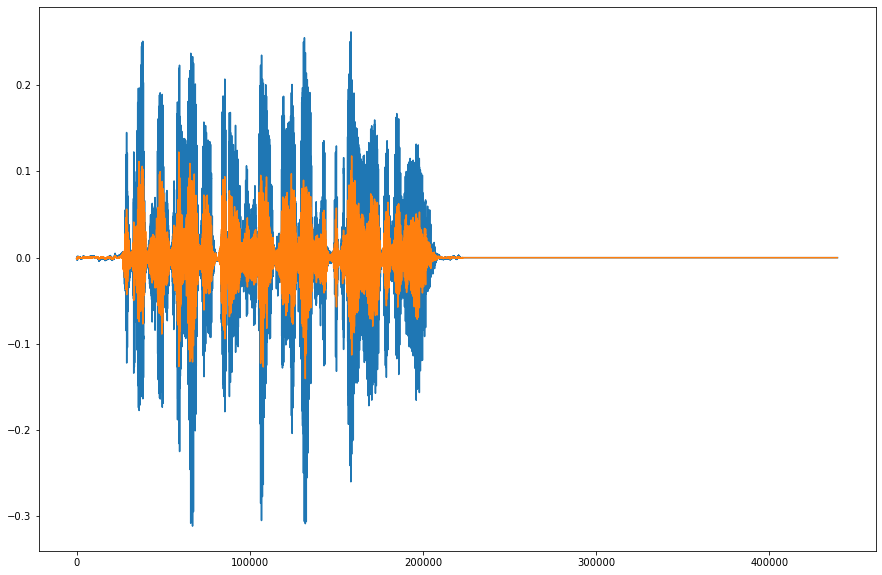

In [138]:
plt.figure(figsize=(15,10))
x = next(iter(val_dl))
plt.plot(x[1][0].T.cpu())
plt.plot(x[0][0].T.cpu())

In [139]:
display(ipd.Audio(x[0][0].squeeze().cpu(), rate=sr));

In [24]:
# loss_batch(model, loss_fun, x.to(dev), x.to(dev))

In [146]:
torch.save(model.state_dict(), "wv.pth")

In [140]:
# x = val_ds[0][0]
tt = x[0][0]
t = tt.squeeze().cpu()
tt = tt.unsqueeze(1)
display(ipd.Audio(t, rate=sr));

In [103]:
net = DenoisingWavenet(config)
net.load_state_dict(torch.load("wv.pth"))
net.to(dev);

In [104]:
tt.shape

torch.Size([1, 1, 388608])

In [141]:
idx = np.arange(0, tt.shape[-1], sampleSize)
out = torch.tensor([]).to(dev)
for i, ind in enumerate(idx):
    if (tt[0, 0, ind:ind + sampleSize].shape[0] < (sampleSize)):
        print("!")
        break
    with torch.no_grad():
        o = net(tt[:, :, ind:ind + sampleSize])
        out = torch.cat([out, o], dim=1)


!


In [142]:
display(ipd.Audio(out.cpu(), rate=sr));

In [42]:
# with torch.no_grad():
#     y = net(tt)
# display(ipd.Audio(y, rate=sr));

RuntimeError: CUDA out of memory. Tried to allocate 266.00 MiB (GPU 0; 11.00 GiB total capacity; 8.38 GiB already allocated; 204.27 MiB free; 9.17 GiB reserved in total by PyTorch)

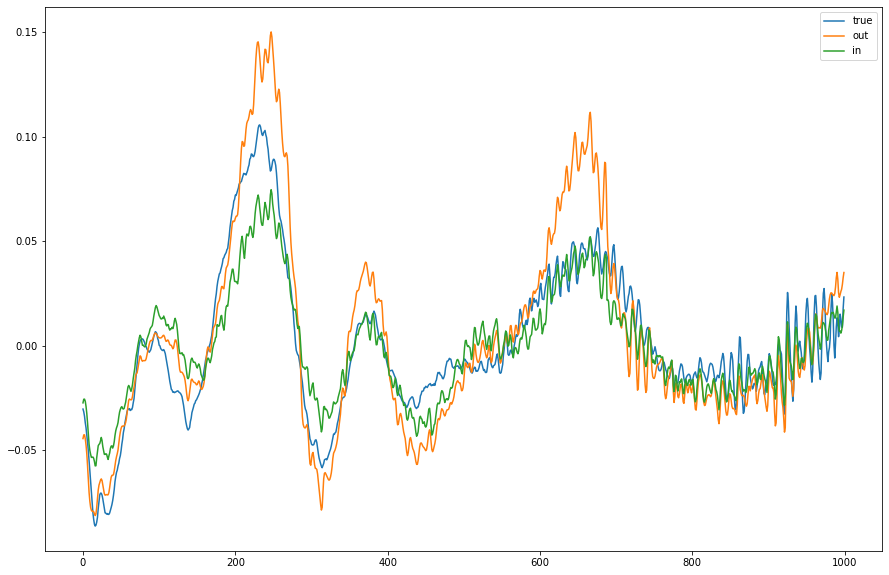

In [145]:
sl = slice(50000, 51000)
plt.figure(figsize=(15, 10))
# plt.plot(y.T)
plt.plot(x[1][0][:,sl].T.cpu())
plt.plot(out[:,sl].T.cpu())
plt.plot(x[0][0][:,sl].T.cpu())
plt.legend(["true", "out", "in"])
# plt.plot(t[:100000])


In [46]:
mu_law_e = transforms.MuLawEncoding()

In [45]:
out.shape

torch.Size([1, 323584])

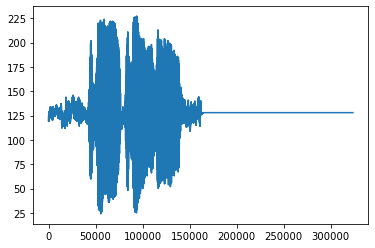

In [50]:
plt.plot(mu_law_e(out).T.cpu())

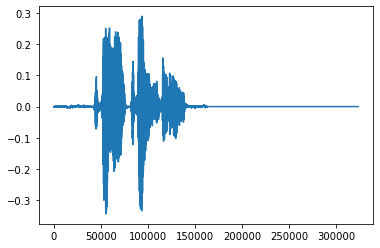

In [51]:
plt.plot(out.T.cpu())